In [1]:
from google.colab import files

print("Please upload your kaggle.json file")
files.upload() # This will open a file upload dialog

Please upload your kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samy09","key":"9436d387c6e756e1a8418bafb4f3427b"}'}

In [2]:
# Make directory named kaggle and copy kaggle.json file there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permissions of the file.
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install kaggle

In [4]:
# Replace 'username/dataset-name' with the actual command you copied
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset
# OR for competitions (you might need to accept rules on the Kaggle site first):
# !kaggle competitions download -c competition-name

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors


In [5]:
# List files to find the zip file name
!ls

kaggle.json  new-plant-diseases-dataset.zip  sample_data


In [6]:
!unzip new-plant-diseases-dataset.zip -d dataset_folder

Streaming output truncated to the last 5000 lines.
  inflating: dataset_folder/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: dataset_folder/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: dataset_folder/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: dataset_folder/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: dataset_folder/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_H

In [7]:
!pip install torchsummary

In [8]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import seaborn as sns
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [9]:
import os

# --- FIND THE CORRECT BASE PATH FIRST ---
# Use the file browser or !ls commands to confirm this path is correct in *your* Colab session!
# It might be different depending on where exactly you unzipped.
# Check if the 'New Plant Diseases Dataset(Augmented)' folder exists directly inside 'dataset_folder'
# or if there's another level. Let's assume the structure from your original path is correct *after* the unzip location:

base_path_in_colab = "/content/dataset_folder/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)" #<-- ADJUST THIS PATH

# Verify the base path exists
if not os.path.exists(base_path_in_colab):
  print(f"ERROR: Base path not found at '{base_path_in_colab}'")
  print("Please use the file browser or !ls to find the correct path and update the 'base_path_in_colab' variable.")
else:
  print(f"Base path found: {base_path_in_colab}")

  data_dir = base_path_in_colab # Use the correct Colab path
  train_dir = os.path.join(data_dir, "train") # Using os.path.join is safer
  valid_dir = os.path.join(data_dir, "valid")

  print(f"Looking for train directory at: {train_dir}")
  print(f"Looking for validation directory at: {valid_dir}")

  # Check if train directory exists before listing
  if os.path.exists(train_dir):
      diseases = os.listdir(train_dir)
      print("\nSuccessfully found train directory.")
      print(f"Found {len(diseases)} classes (diseases):")
      print(diseases)
  else:
      print(f"\nERROR: Train directory not found at '{train_dir}'")
      print("Check the 'base_path_in_colab' and the unzipped folder structure.")

  # You can also check the validation directory
  if os.path.exists(valid_dir):
    print("\nSuccessfully found validation directory.")
  else:
    print(f"\nERROR: Validation directory not found at '{valid_dir}'")

Base path found: /content/dataset_folder/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)
Looking for train directory at: /content/dataset_folder/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
Looking for validation directory at: /content/dataset_folder/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid

Successfully found train directory.
Found 38 classes (diseases):
['Pepper,_bell___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Apple___Apple_scab', 'Tomato___Target_Spot', 'Peach___healthy', 'Grape___Black_rot', 'Apple___healthy', 'Tomato___healthy', 'Tomato___Septoria_leaf_spot', 'Raspberry___healthy', 'Squash___Powdery_mildew', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Strawberry___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Peach___Bacterial_spot', 'Potato___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Pepper,_bell___Bacterial_spot', 'Blueberry___healthy'

In [10]:
print(diseases)

['Pepper,_bell___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Apple___Apple_scab', 'Tomato___Target_Spot', 'Peach___healthy', 'Grape___Black_rot', 'Apple___healthy', 'Tomato___healthy', 'Tomato___Septoria_leaf_spot', 'Raspberry___healthy', 'Squash___Powdery_mildew', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Strawberry___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Peach___Bacterial_spot', 'Potato___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Pepper,_bell___Bacterial_spot', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Apple___Cedar_apple_rust', 'Strawberry___Leaf_scorch', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Early_blight', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Corn_(maize)___healthy', 'Tomato___Leaf_Mold', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Corn_(maize)___Common_rust_', 'Tomato___Bacterial_spot', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___healthy', 'Apple___Black_rot', 'Grape___E

In [11]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 38


In [12]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [13]:
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Pepper,_bell', 'Orange', 'Apple', 'Tomato', 'Peach', 'Grape', 'Raspberry', 'Squash', 'Strawberry', 'Potato', 'Cherry_(including_sour)', 'Blueberry', 'Corn_(maize)', 'Soybean']


In [14]:
# number of unique plants
print("Number of plants: {}".format(len(plants)))

Number of plants: 14


In [15]:
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 26


In [16]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

no. of images
Pepper,_bell___healthy                                       1988
Orange___Haunglongbing_(Citrus_greening)                     2010
Apple___Apple_scab                                           2016
Tomato___Target_Spot                                         1827
Peach___healthy                                              1728
Grape___Black_rot                                            1888
Apple___healthy                                              2008
Tomato___healthy                                             1926
Tomato___Septoria_leaf_spot                                  1745
Raspberry___healthy                                          1781
Squash___Powdery_mildew                                      1736
Tomato___Tomato_Yellow_Leaf_Curl_Virus                       1961
Strawberry___healthy                                         1824
Potato___Early_blight                                        1939
Potato___Late_blight                                         1939
Peach___Bacterial_spot                                       1838
Potato___healthy                                             1824
Cherry_(including_sour)___Powdery_mildew                     1683
Pepper,_bell___Bacterial_spot                                1913
Blueberry___healthy                                          1816
Cherry_(including_sour)___healthy                            1826
Apple___Cedar_apple_rust                                     1760
Strawberry___Leaf_scorch                                     1774
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot           1642
Tomato___Early_blight                                        1920
Tomato___Spider_mites Two-spotted_spider_mite                1741
Corn_(maize)___healthy                                       1859
Tomato___Leaf_Mold                                           1882
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                   1722
Corn_(maize)___Common_rust_                                  1907
Tomato___Bacterial_spot                                      1702
Corn_(maize)___Northern_Leaf_Blight                          1908
Grape___healthy                                              1692
Apple___Black_rot                                            1987
Grape___Esca_(Black_Measles)                                 1920
Soybean___healthy                                            2022
Tomato___Tomato_mosaic_virus                                 1790
Tomato___Late_blight                                         1851

<ipython-input-17-6249421a4106>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x= Len, y= plant_names, palette="Greens")


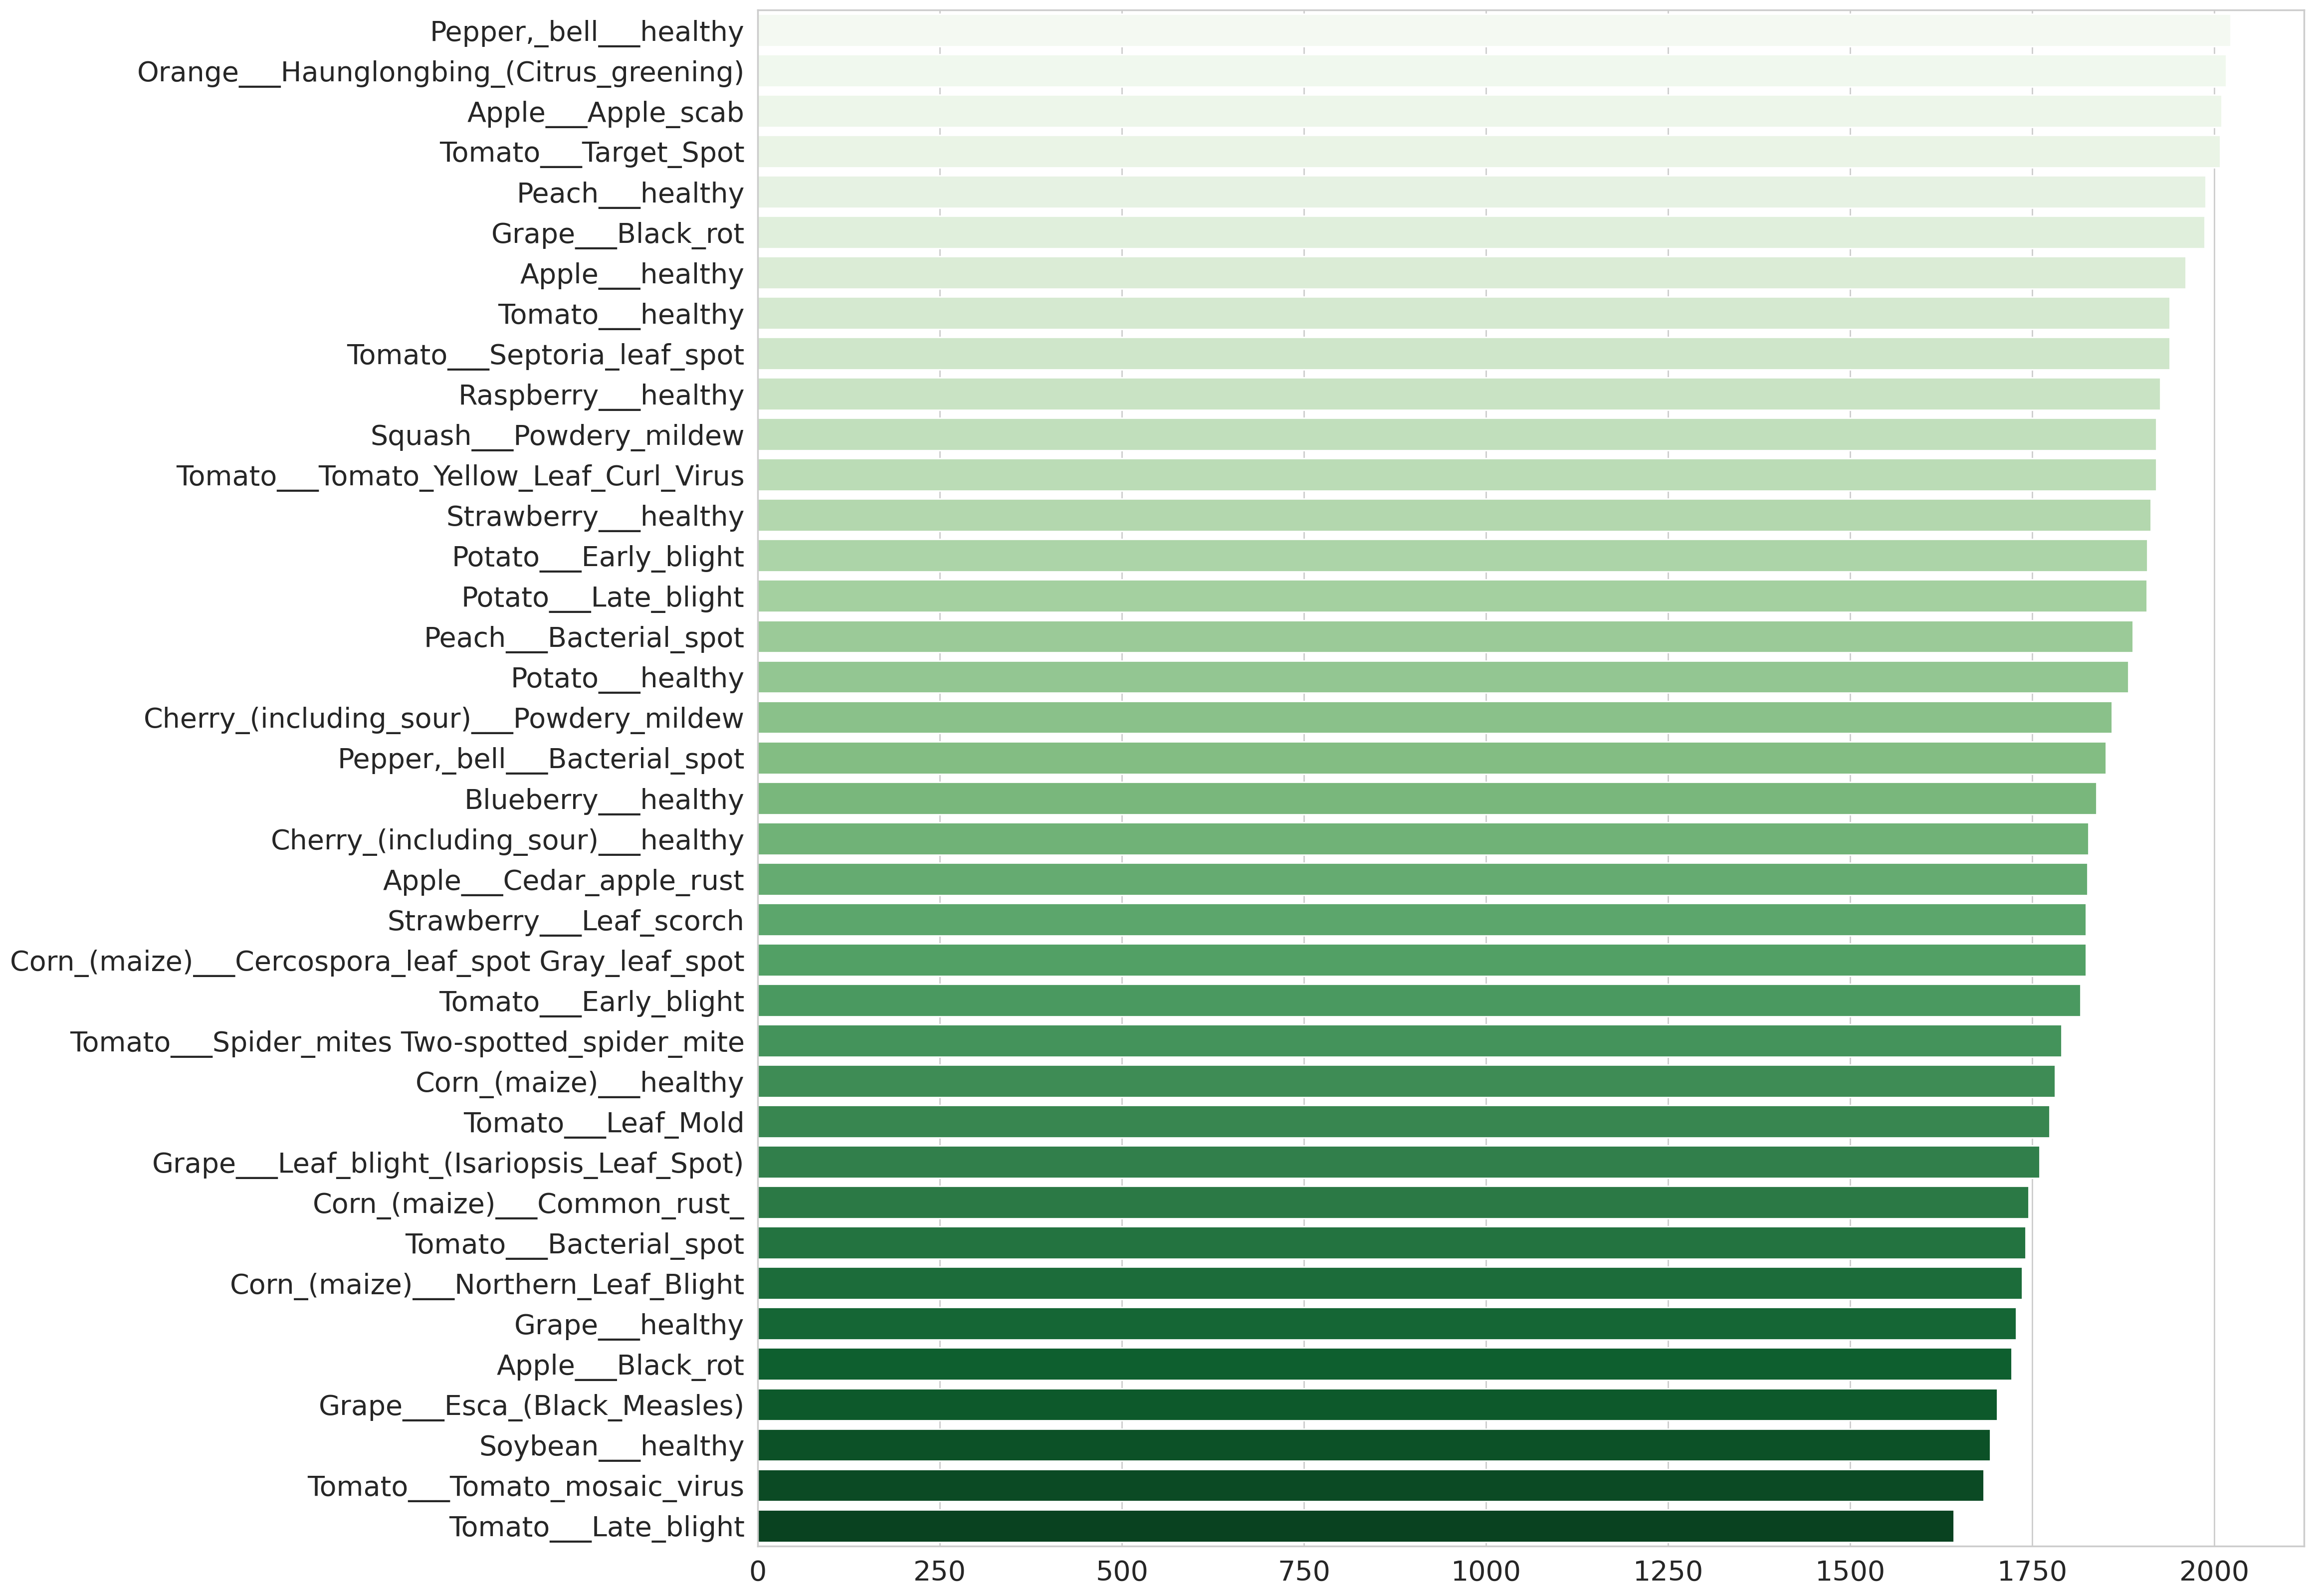

In [17]:
import seaborn as sns
plant_names = []
Len = []
for i in diseases:
    plant_names.append(i)
    imgs_path = os.listdir(train_dir + "/" + i)
    Len.append(len(imgs_path))

Len.sort(reverse=True)

sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,20),dpi=200)
ax = sns.barplot(x= Len, y= plant_names, palette="Greens")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [18]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 70295 images for training


# Data Preparation

In [19]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

In [20]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [21]:
# total number of classes in train set
len(train.classes)

38

In [22]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :Apple___Apple_scab(0)


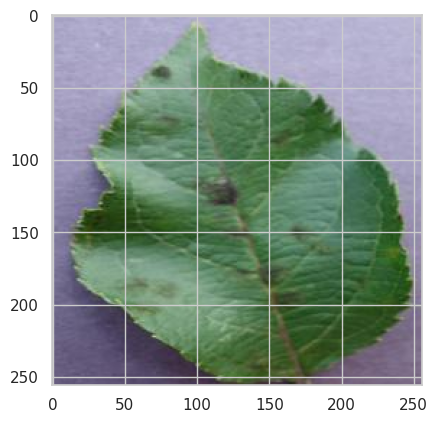

In [23]:
show_image(*train[0])

Label :Tomato___healthy(37)


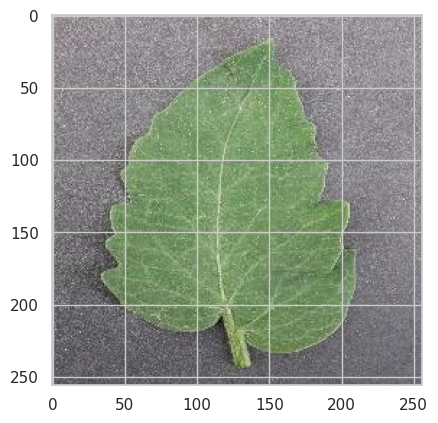

In [24]:
show_image(*train[70000])

In [25]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [26]:
# setting the batch size
batch_size = 32

In [27]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [28]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

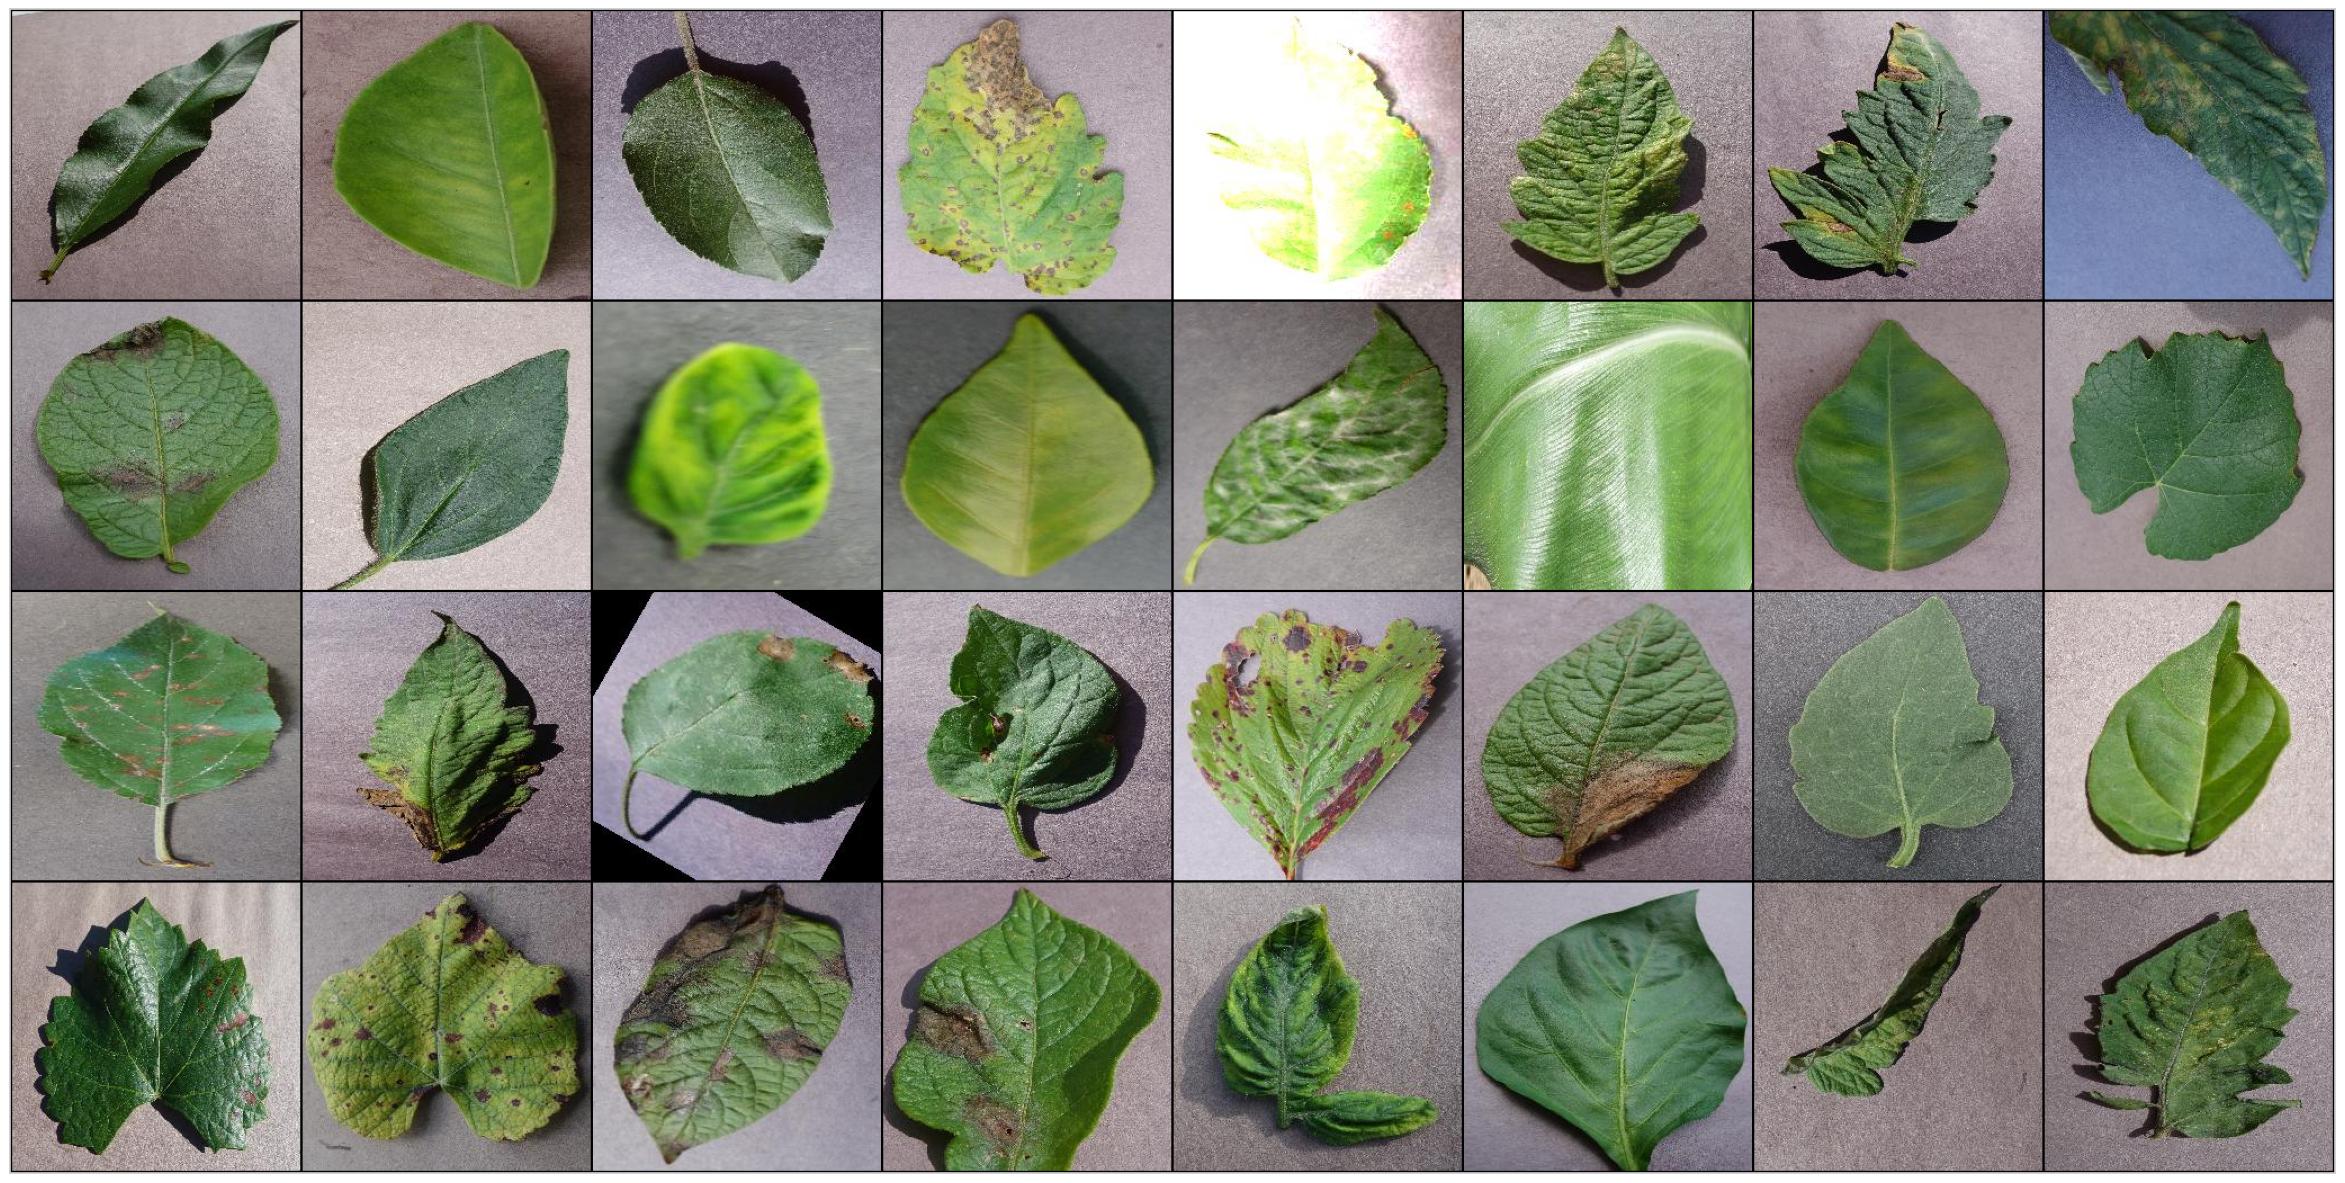

In [29]:
# Images for first batch of training
show_batch(train_dl)

# Modelling

In [30]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [31]:
device = get_default_device()
device

device(type='cuda')

In [32]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [33]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [34]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate prediction
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        preds = torch.argmax(out, dim=1)      # Get class predictions
        return {
            "val_loss": loss.detach(),
            "val_accuracy": acc,
            "preds": preds.detach(),  # Add predictions
            "labels": labels.detach() # Add ground truth
        }

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [35]:
# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))

    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [36]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [37]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

# Training the model

In [38]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]

    # Combine predictions and labels across batches
    preds = torch.cat([x['preds'] for x in outputs]).cpu().numpy()
    labels = torch.cat([x['labels'] for x in outputs]).cpu().numpy()

    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)

    # Get original metrics
    result = model.validation_epoch_end(outputs)
    result['confusion_matrix'] = cm
    return result


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()


        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [39]:
%%time
history = [evaluate(model, valid_dl)]
history


CPU times: user 50.5 s, sys: 4.34 s, total: 54.8 s
Wall time: 1min 12s


[{'val_loss': tensor(3.6378, device='cuda:0'),
  'val_accuracy': tensor(0.0282),
  'confusion_matrix': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])}]

In [40]:
epochs = 10
max_lr = 0.01
grad_clip = 1.0
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [41]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=1e-4,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00280, train_loss: 0.5819, val_loss: 3.2542, val_acc: 0.4778
Epoch [1], last_lr: 0.00760, train_loss: 0.3439, val_loss: 0.7036, val_acc: 0.7868
Epoch [2], last_lr: 0.01000, train_loss: 0.2925, val_loss: 0.3411, val_acc: 0.8944
Epoch [3], last_lr: 0.00950, train_loss: 0.2332, val_loss: 0.4375, val_acc: 0.8681
Epoch [4], last_lr: 0.00812, train_loss: 0.1835, val_loss: 0.1847, val_acc: 0.9420
Epoch [5], last_lr: 0.00611, train_loss: 0.1338, val_loss: 0.1349, val_acc: 0.9547
Epoch [6], last_lr: 0.00389, train_loss: 0.0938, val_loss: 0.0754, val_acc: 0.9756
Epoch [7], last_lr: 0.00188, train_loss: 0.0556, val_loss: 0.0551, val_acc: 0.9813
Epoch [8], last_lr: 0.00050, train_loss: 0.0238, val_loss: 0.0256, val_acc: 0.9917
Epoch [9], last_lr: 0.00000, train_loss: 0.0104, val_loss: 0.0226, val_acc: 0.9924
CPU times: user 1h 25min 50s, sys: 1h 8min 57s, total: 2h 34min 47s
Wall time: 2h 36min 7s


# Plotting

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    # Convert CUDA tensors to CPU floats
    train_losses = []
    for x in history:
        tl = x.get('train_loss')
        if tl is not None:
            if isinstance(tl, torch.Tensor):
                tl = tl.detach().cpu().item()  # Convert to Python float
            train_losses.append(tl)
        else:
            train_losses.append(None)

    val_losses = []
    for x in history:
        vl = x['val_loss']
        if isinstance(vl, torch.Tensor):
            vl = vl.detach().cpu().item()
        val_losses.append(vl)

    # Plot
    plt.plot(train_losses, '-bx', label='Training')
    plt.plot(val_losses, '-rx', label='Validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

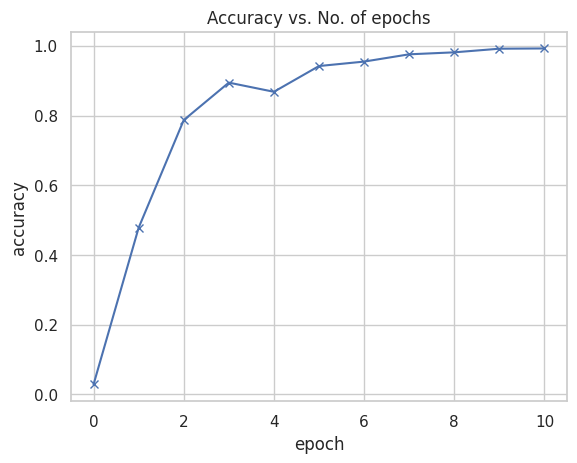

In [43]:
plot_accuracies(history)

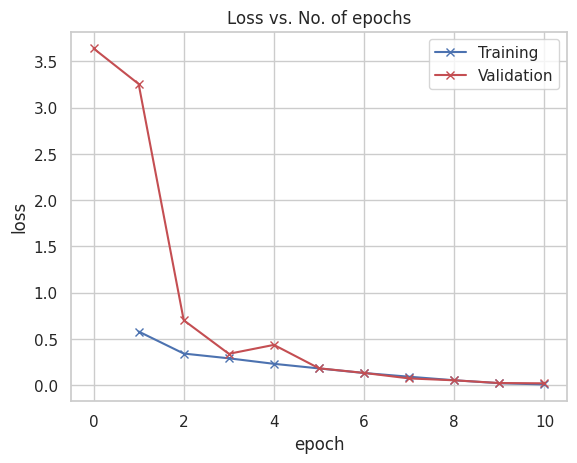

In [44]:
plot_losses(history)

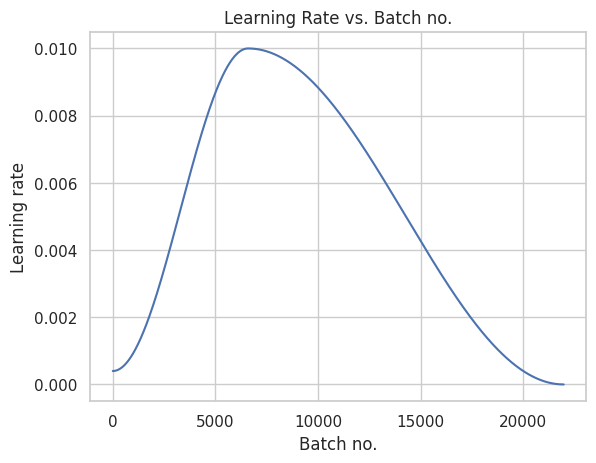

In [45]:
plot_lrs(history)

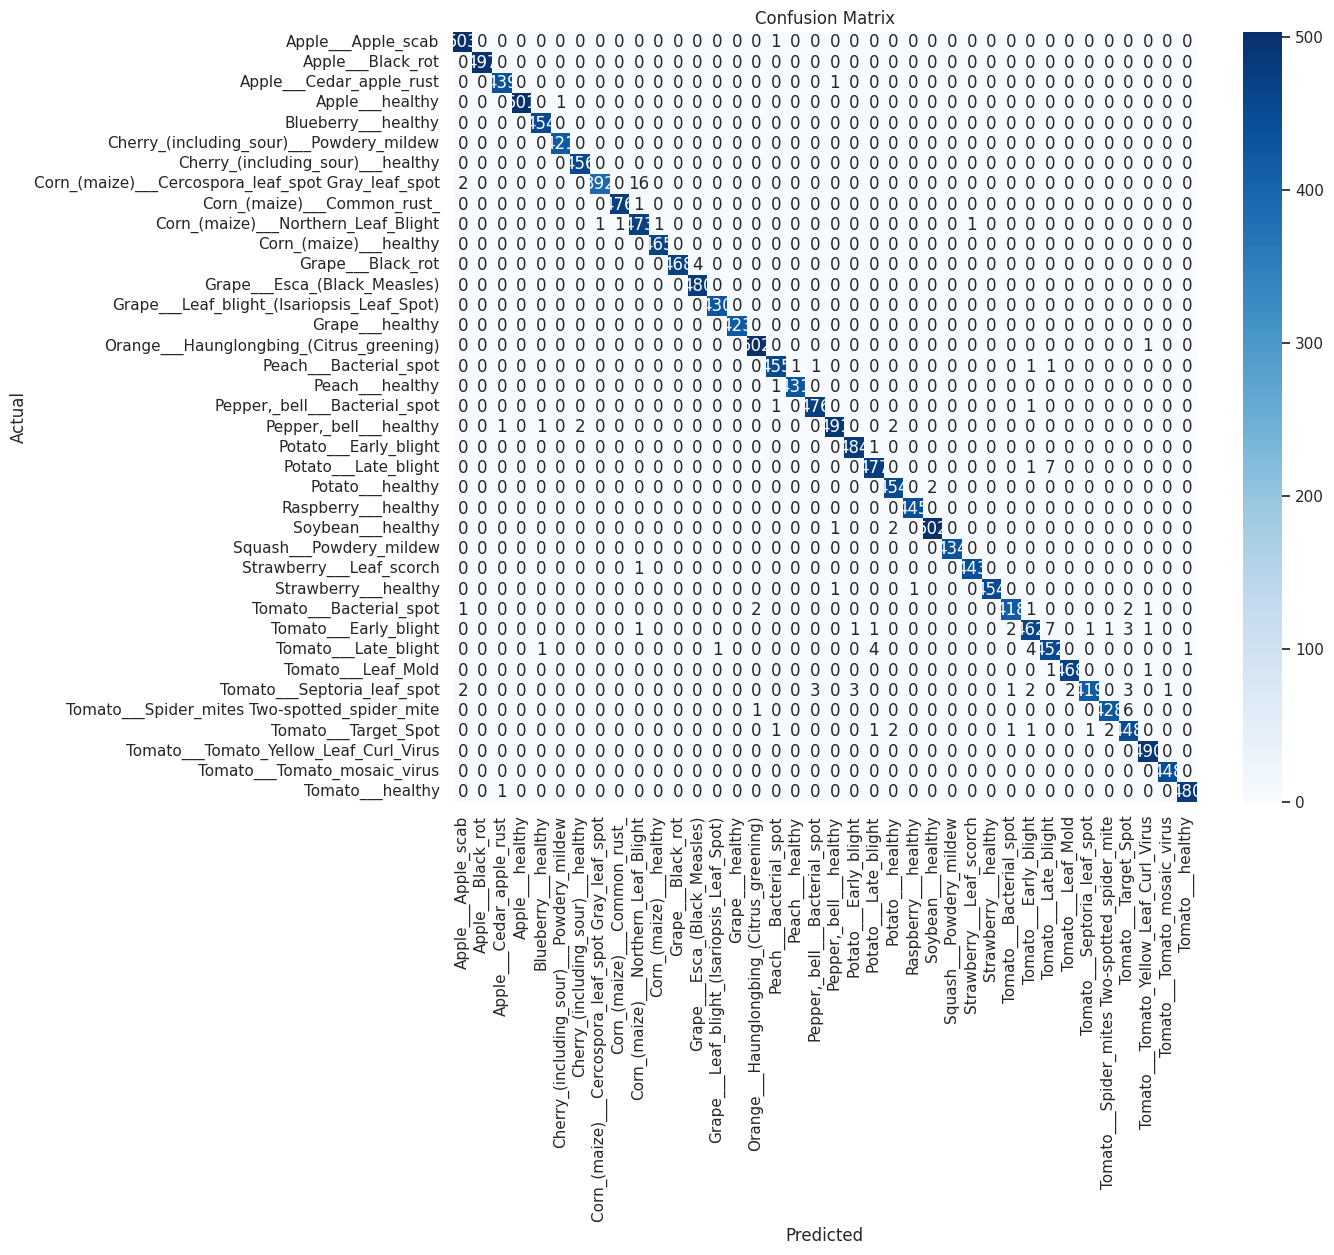

In [62]:
# After training, get the confusion matrix from the last validation result
cm = history[-1]['confusion_matrix']
plot_confusion_matrix(cm, class_names=train.classes)

# Testing model

In [50]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

test_dir = "/content/dataset_folder/test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [51]:
test_images = sorted(os.listdir(test_dir + '/test')) # since images in test folder are in alphabetical order
test_images

['AppleCedarRust1.JPG',
 'AppleCedarRust2.JPG',
 'AppleCedarRust3.JPG',
 'AppleCedarRust4.JPG',
 'AppleScab1.JPG',
 'AppleScab2.JPG',
 'AppleScab3.JPG',
 'CornCommonRust1.JPG',
 'CornCommonRust2.JPG',
 'CornCommonRust3.JPG',
 'PotatoEarlyBlight1.JPG',
 'PotatoEarlyBlight2.JPG',
 'PotatoEarlyBlight3.JPG',
 'PotatoEarlyBlight4.JPG',
 'PotatoEarlyBlight5.JPG',
 'PotatoHealthy1.JPG',
 'PotatoHealthy2.JPG',
 'TomatoEarlyBlight1.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoEarlyBlight3.JPG',
 'TomatoEarlyBlight4.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoEarlyBlight6.JPG',
 'TomatoHealthy1.JPG',
 'TomatoHealthy2.JPG',
 'TomatoHealthy3.JPG',
 'TomatoHealthy4.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'TomatoYellowCurlVirus6.JPG']

In [55]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust


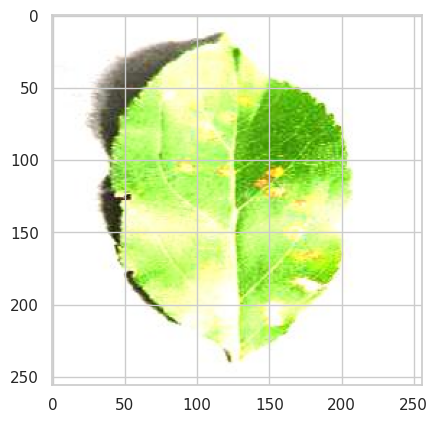

In [56]:
# predicting first image
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

In [57]:
# getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust2.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust3.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust4.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleScab1.JPG , Predicted: Apple___Apple_scab
Label: AppleScab2.JPG , Predicted: Apple___Apple_scab
Label: AppleScab3.JPG , Predicted: Apple___Apple_scab
Label: CornCommonRust1.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust2.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust3.JPG , Predicted: Corn_(maize)___Common_rust_
Label: PotatoEarlyBlight1.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight2.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight3.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight4.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight5.JPG , Predicted: Potato___Early_blight
Label: PotatoHealthy1.JPG , Predicted: Potato___h

# Saving the model

In [63]:
import torch

# Save the model
torch.save(model.state_dict(), 'model.pt')

In [64]:
torch.save(model, 'model_full.pt')

In [65]:
from google.colab import files
files.download('model.pt')
files.download('model_full.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>